In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Section 1: Ingesting data and setup

In [8]:
# Ingest the data
data = '../Data/accident_data.csv'
df = pd.read_csv(data)
df.head()

,CRASH_CRN,DISTRICT,CRASH_COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,HOUR_OF_DAY,...,LANE_COUNT,RDWY_ORIENT,ROAD_OWNER,ROUTE,SPEED_LIMIT,SEGMENT,OFFSET,STREET_NAME,TOT_INJ_COUNT,SCHOOL_BUS_UNIT
0,2004000001,11,2,2454,02454,2004,1,5,257.0,2.0,...,2.0,E,2.0,2032,35.0,10.0,1000.0,LEWIS RUN RD,NaN,NaN
1,2004000010,11,2,2440,02440,2004,1,5,1027.0,10.0,...,2.0,W,3.0,NaN,35.0,NaN,NaN,COAL VALLEY RD,NaN,NaN
2,2004000016,11,2,2203,02203,2004,1,5,1839.0,18.0,...,2.0,W,2.0,3082,35.0,NaN,NaN,CLINTON FRANKFORT RD,NaN,NaN
3,2004000022,11,2,2404,02404,2004,1,6,914.0,9.0,...,2.0,N,4.0,NaN,25.0,NaN,NaN,NORTH BALPH AV,NaN,NaN
4,2004000030,11,2,2419,02419,2004,1,5,2230.0,22.0,...,2.0,S,4.0,NaN,20.0,NaN,NaN,THORNBERRY DR,NaN,NaN


In [9]:
# Data dictionary
data_dict = '../Data/accident_data_dict.csv'
data_dict = pd.read_csv(data_dict)
data_dict

,column,type,label,description
0,CRASH_CRN,text,Crash Number\t,Crash Record Number\t
1,DISTRICT,text,District\t,District Number where crash occurred
2,CRASH_COUNTY,text,County\t,County Code Number where crash occurred
3,MUNICIPALITY,text,Municipality,County Municipality Code
4,POLICE_AGCY,text,Police Agency Code,Code of the reporting Police Agency
...,...,...,...,...
185,SEGMENT,text,Segment Number,Segment Number– only for state roads\t
186,OFFSET,int4,Offset within Segment,Offset (in feet) within the Segment – only for...
187,STREET_NAME,text,Street Name,Name of the Roadway
188,TOT_INJ_COUNT,int4,Total Injury Count,Total Injuries\t


In [10]:
# To check what any column means
def col_info(col_names_list):
    return data_dict[data_dict.column.isin(col_names_list)]
    
col_names_list = ['LANE_COUNT']
col_info(col_names_list)


,column,type,label,description
180,LANE_COUNT,int4,Lane Count,Travel Lane Count


### Section 2: Checks and cleaning if required

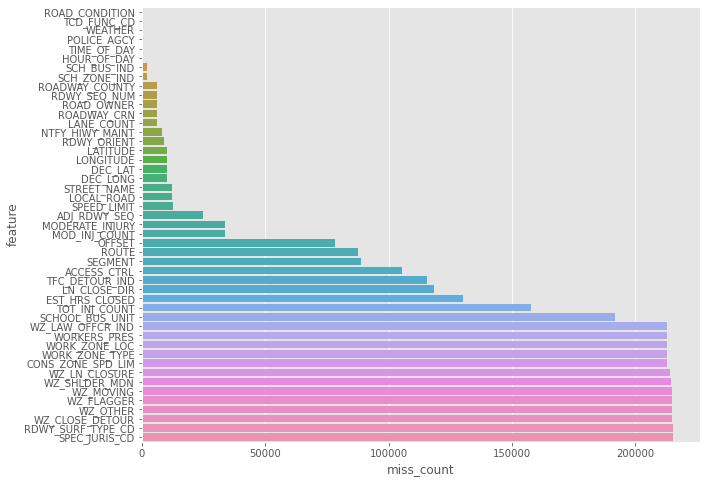

In [11]:
# Missing values
# Visualizing missing values
def plot_missing(theDataFrame, fs=(10,8)):
    """
    Graph the number of missing values in each column (each feature)
    
    return:
    None
    """
    # A new dataframe that contains the count of null items for each category (axis=0)
    missingvals_df = theDataFrame.isnull().sum(axis=0).reset_index()
    missingvals_df.columns = ['feature', 'miss_count'] # Rename the column names to feature and miss count
    missingvals_df = missingvals_df.loc[missingvals_df['miss_count'] > 0] # Filter out the features that have values for every entry
    missingvals_df = missingvals_df.sort_values(by='miss_count') # Sort

    # Plot
    fig, ax = plt.subplots(figsize=fs)
    sns.barplot(data=missingvals_df, x='miss_count', y='feature', orient='h', ax=ax)
    plt.show()
    
    return missingvals_df

missing_dfs = plot_missing(df)


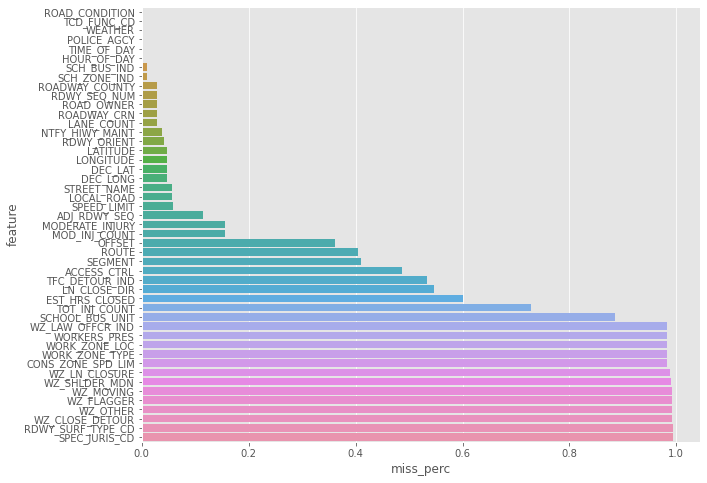

In [12]:
# Missing values
# Visualizing missing value percentages
def plot_missing(theDataFrame, fs=(10,8)):
    """
    Graph the number of missing values in each column (each feature)
    
    return:
    None
    """
    # A new dataframe that contains the count of null items for each category (axis=0)
    missingvals_df = theDataFrame.isnull().mean(axis=0).reset_index()
    missingvals_df.columns = ['feature', 'miss_perc'] # Rename the column names to feature and miss count
    missingvals_df = missingvals_df.loc[missingvals_df['miss_perc'] > 0] # Filter out the features that have values for every entry
    missingvals_df = missingvals_df.sort_values(by='miss_perc') # Sort

    # Plot
    fig, ax = plt.subplots(figsize=fs)
    sns.barplot(data=missingvals_df, x='miss_perc', y='feature', orient='h', ax=ax)
    plt.show()
    
    return missingvals_df

missing_dfs = plot_missing(df)


In [13]:
# Let's check what the highly missing variables are
high_missing_cols = list(missing_dfs.tail(10)['feature'])
col_info(high_missing_cols)

,column,type,label,description
69,RDWY_SURF_TYPE_CD,text,Roadway Surface Type Code\t,Code for the Roadway surface type –only for fa...
70,SPEC_JURIS_CD,text,Special Jurisdiction Code,Code that defines any special jurisdiction – o...
74,WORK_ZONE_TYPE,text,Work Zone Type Code\t,Code to define the type of Work Zone\r\n1 - Co...
76,CONS_ZONE_SPD_LIM,int4,Construction Zone Speed Limit,Speed limit for the Construction Zone
78,WZ_CLOSE_DETOUR,text,Work Zone Closed Detour\t,Was traffic rerouted due to work zone?(Y/N); 0...
79,WZ_FLAGGER,text,Work Zone Flagman Flag\t,"Did Work zone have a flagman? (Y/N) 0 = No, 1 ..."
81,WZ_LN_CLOSURE,text,Work Zone Lane Closure Flag\t,"Did Work zone have a patrolman? (Y/N) 0 = No, ..."
82,WZ_MOVING,text,Work Zone Moving Flag\t,Was there moving work in the zone? (Y/N) 0 = N...
83,WZ_OTHER,text,Work Zone Special Flag\t,Was this a special type of work zone? (Y/N) 0 ...
84,WZ_SHLDER_MDN,text,Work Zone Shoulder/Median Flag\t,Was a median/shoulder in the zone?; (Y/N) 0 = ...


We probably shouldn't drop anything now, as some of these columns may not really be required. Depending on what specific modelling we do, we can do ML modelling specific cleaning then

### Section 3: Some data exploration (Small trucks involved)

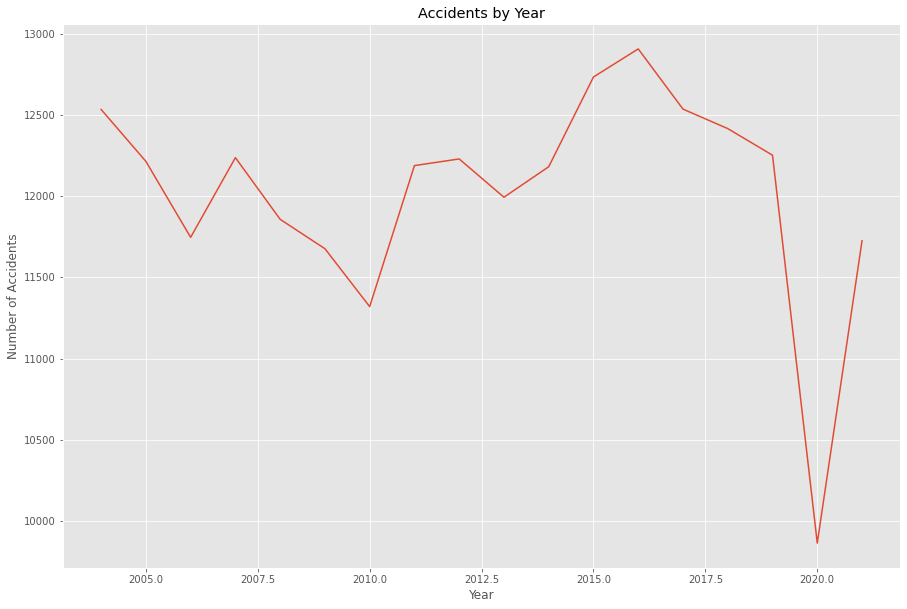

In [14]:
# Counts of accidents by year
df['CRASH_YEAR'] = pd.to_datetime(df['CRASH_YEAR'], format='%Y')

# create a new DataFrame with the counts of accidents by year
accidents_by_year = df.groupby(df['CRASH_YEAR'].dt.year).size().reset_index(name='counts')

# plot the counts of accidents by year using a line chart
plt.figure(figsize=(15,10))
plt.plot(accidents_by_year['CRASH_YEAR'], accidents_by_year['counts'])
plt.title('Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()


<Figure size 1080x720 with 0 Axes>

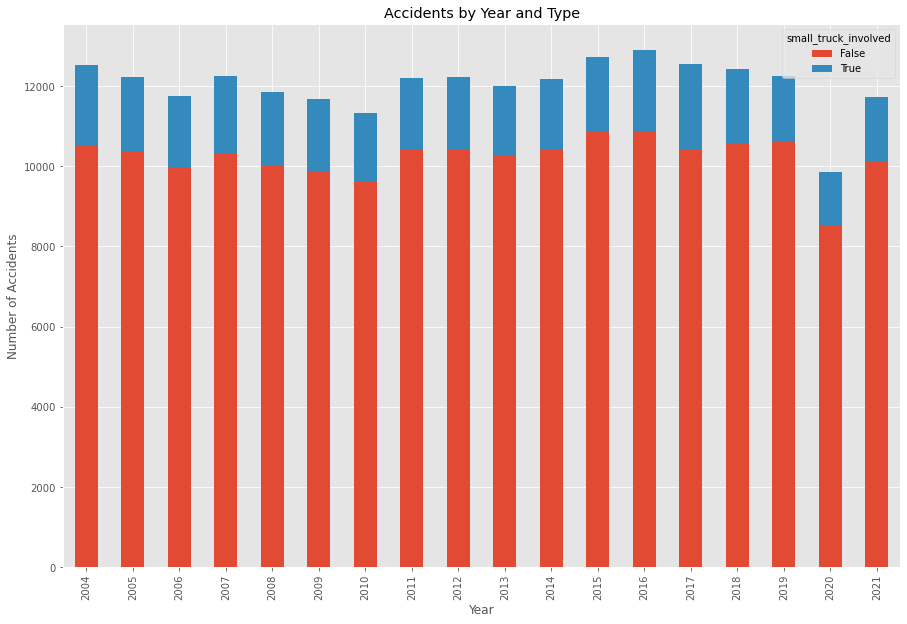

In [15]:
# Exploring small trucks related accidents
df['small_truck_involved'] = np.where(df['SMALL_TRUCK_COUNT'] > 0, True, False)
df['any_fatalities'] = np.where(df['FATAL_COUNT'] > 0, True, False)
df['any_injuries'] = np.where(df['INJURY_COUNT'] > 0, True, False)
df['any_major_injuries'] = np.where(df['MAJ_INJ_COUNT'] > 0, True, False)


# create a new DataFrame with the counts of accidents by year and type
accidents_by_year_and_type = df.groupby(['CRASH_YEAR', 'small_truck_involved']).size().reset_index(name='counts')

# pivot the DataFrame to create a new DataFrame with year as index and type as columns
accidents_by_year_and_type_pivot = accidents_by_year_and_type.pivot(index='CRASH_YEAR', columns='small_truck_involved', values='counts')

# plot a stacked bar chart of the counts of accidents by year and type
plt.figure(figsize=(15,10))
# create a stacked bar chart of the counts of accidents by year and type
ax = accidents_by_year_and_type_pivot.plot(kind='bar', stacked=True, figsize=(15, 10))

# format the x-axis labels to display only the year
ax.set_xticklabels([x.strftime('%Y') for x in accidents_by_year_and_type_pivot.index])

ax.set_title('Accidents by Year and Type')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Accidents')
plt.show()


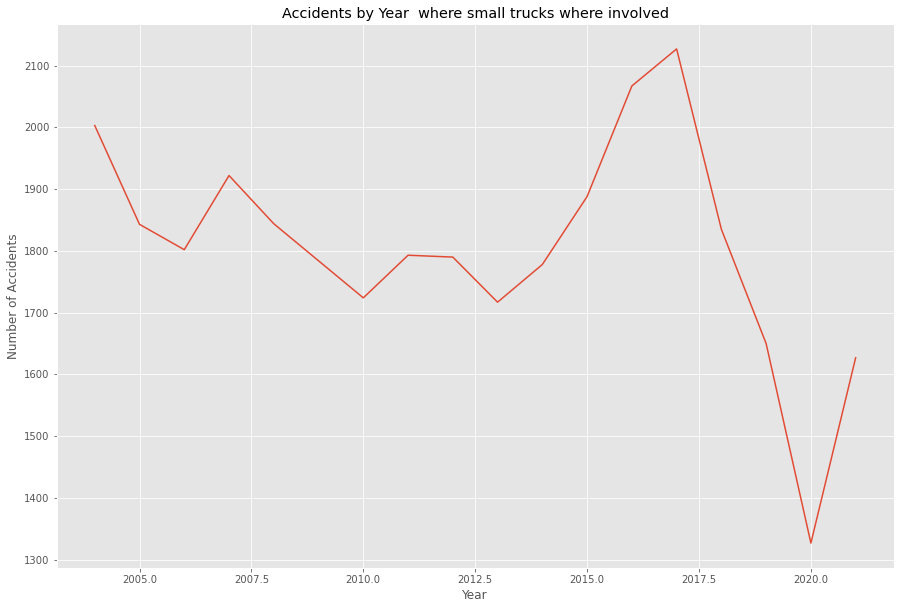

In [16]:
small_truck_accidents = df[df.small_truck_involved == True]

# create a new DataFrame with the counts of accidents by year
accidents_by_year_small_trucks = small_truck_accidents.groupby(df['CRASH_YEAR'].dt.year).size().reset_index(name='counts')

# plot the counts of accidents by year using a line chart
plt.figure(figsize=(15,10))
plt.plot(accidents_by_year_small_trucks['CRASH_YEAR'], accidents_by_year_small_trucks['counts'])
plt.title('Accidents by Year  where small trucks where involved')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()


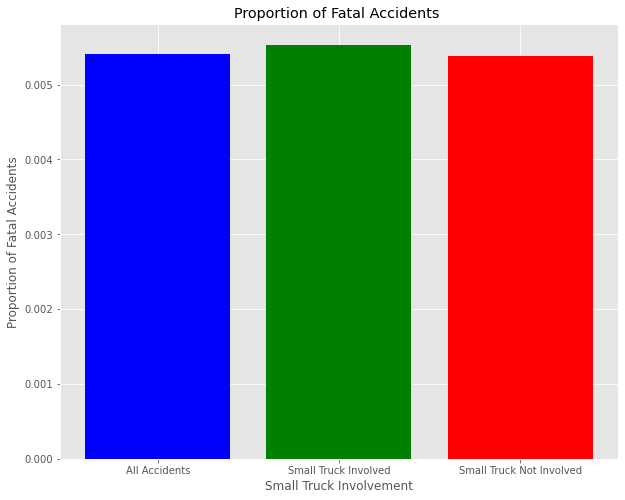

In [17]:
# calculate the total number of accidents and the total number of fatal accidents
total_accidents = df.shape[0]
fatalities_df = df[df['any_fatalities']]
total_fatalities = fatalities_df.shape[0]

# calculate the proportion of accidents that were fatal
all_fatalities_prop = total_fatalities / total_accidents

# calculate the proportion of fatal accidents involving small trucks vs those not involving small trucks
small_truck_fatalities = fatalities_df['small_truck_involved'].sum()
small_truck_total = df['small_truck_involved'].sum()
small_truck_fatalities_prop = [small_truck_fatalities / small_truck_total, (total_fatalities - small_truck_fatalities) / (total_accidents - small_truck_total)]

# create a bar chart with three bars
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(['All Accidents', 'Small Truck Involved', 'Small Truck Not Involved'], [all_fatalities_prop, small_truck_fatalities_prop[0], small_truck_fatalities_prop[1]], color=['b', 'g', 'r'])

# add labels, title, and legend to the plot
ax.set_xlabel('Small Truck Involvement')
ax.set_ylabel('Proportion of Fatal Accidents')
ax.set_title('Proportion of Fatal Accidents ')

plt.show()


Text(0.5, 1.0, 'Proportion of Injury Accidents ')

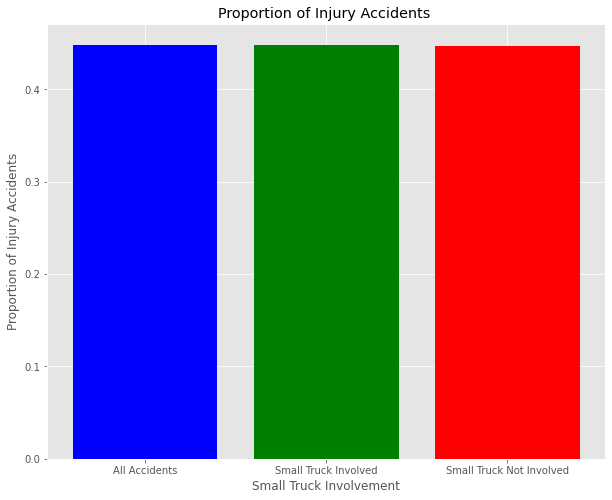

In [18]:
# Similar analysis as above but for any injuries
# calculate the total number of accidents and the total number of injury accidents
total_accidents = df.shape[0]
injuries_df = df[df['any_injuries']]
total_injuries = injuries_df.shape[0]

# calculate the proportion of accidents that were fatal
all_injuries_prop = total_injuries / total_accidents

# calculate the proportion of fatal accidents involving small trucks vs those not involving small trucks
small_truck_injuries = injuries_df['small_truck_involved'].sum()
small_truck_total = df['small_truck_involved'].sum()
small_truck_injuries_prop = [small_truck_injuries / small_truck_total, (total_injuries - small_truck_injuries) / (total_accidents - small_truck_total)]

# create a bar chart with three bars
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(['All Accidents', 'Small Truck Involved', 'Small Truck Not Involved'], [all_injuries_prop, small_truck_injuries_prop[0], small_truck_injuries_prop[1]], color=['b', 'g', 'r'])

# add labels, title, and legend to the plot
ax.set_xlabel('Small Truck Involvement')
ax.set_ylabel('Proportion of Injury Accidents')
ax.set_title('Proportion of Injury Accidents ')



Text(0.5, 1.0, 'Proportion of Major Injury Accidents ')

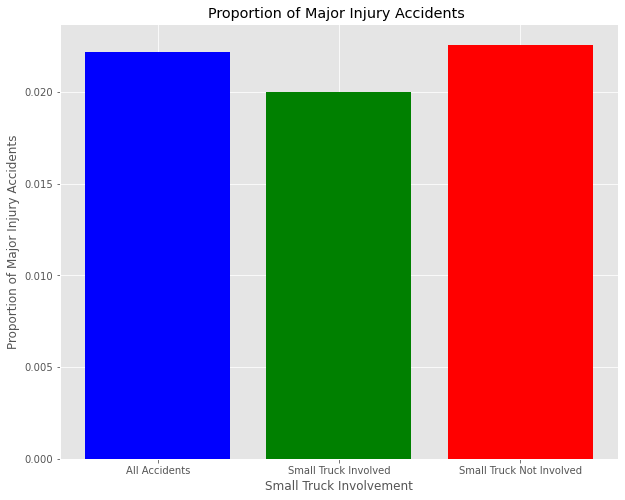

In [19]:
# Major injuries
# calculate the total number of accidents and the total number of injury accidents
total_accidents = df.shape[0]
maj_injuries_df = df[df['any_major_injuries']]
total_maj_injuries = maj_injuries_df.shape[0]

# calculate the proportion of accidents that were fatal
all_maj_injuries_prop = total_maj_injuries / total_accidents

# calculate the proportion of fatal accidents involving small trucks vs those not involving small trucks
small_truck_maj_injuries = maj_injuries_df['small_truck_involved'].sum()
small_truck_total = df['small_truck_involved'].sum()
small_truck_maj_injuries_prop = [small_truck_maj_injuries / small_truck_total, (total_maj_injuries - small_truck_maj_injuries) / (total_accidents - small_truck_total)]

# create a bar chart with three bars
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(['All Accidents', 'Small Truck Involved', 'Small Truck Not Involved'], [all_maj_injuries_prop, small_truck_maj_injuries_prop[0], small_truck_maj_injuries_prop[1]], color=['b', 'g', 'r'])

# add labels, title, and legend to the plot
ax.set_xlabel('Small Truck Involvement')
ax.set_ylabel('Proportion of Major Injury Accidents')
ax.set_title('Proportion of Major Injury Accidents ')


### Section 4: Death related accidents exploration

In [20]:
df_deaths = df[df.FATAL==True]
len(df_deaths)

1166

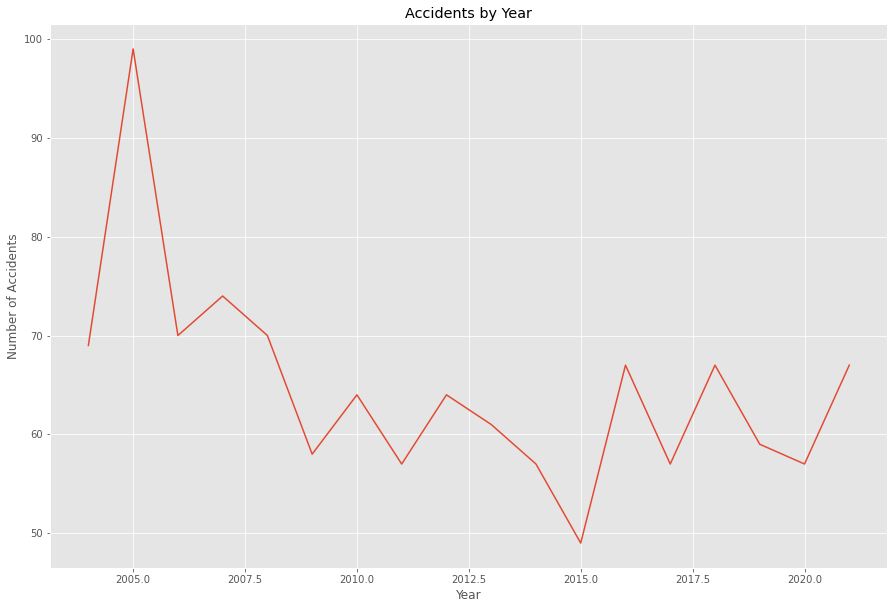

In [21]:
# Death related accidents over time
# create a new DataFrame with the counts of accidents by year
accidents_by_year = df_deaths.groupby(df_deaths['CRASH_YEAR'].dt.year).size().reset_index(name='counts')

# plot the counts of accidents by year using a line chart
plt.figure(figsize=(15,10))
plt.plot(accidents_by_year['CRASH_YEAR'], accidents_by_year['counts'])
plt.title('Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()


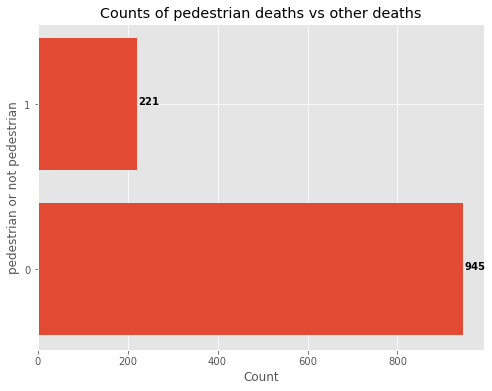

In [22]:
# How many of these deaths involved pedestrians
counts = df_deaths.groupby('PEDESTRIAN').size()

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(counts.index.astype(str), counts.values)

# add labels to the bars
for i, v in enumerate(counts.values):
    ax.text(v + 3, i, str(v), color='black', fontweight='bold')

# add labels and a title to the plot
ax.set_xlabel('Count')
ax.set_ylabel('pedestrian or not pedestrian')
ax.set_title('Counts of pedestrian deaths vs other deaths')

plt.show()


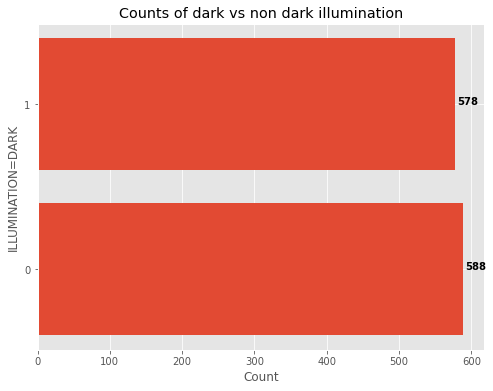

In [23]:
# Illumination flag
# How many of these deaths involved pedestrians
counts = df_deaths.groupby('ILLUMINATION_DARK').size()

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(counts.index.astype(str), counts.values)

# add labels to the bars
for i, v in enumerate(counts.values):
    ax.text(v + 3, i, str(v), color='black', fontweight='bold')

# add labels and a title to the plot
ax.set_xlabel('Count')
ax.set_ylabel('ILLUMINATION=DARK')
ax.set_title('Counts of dark vs non dark illumination')

plt.show()


### TO DO analysis:

- Driver Age distribution of major injury/death accidents
- drunk driver
- specific kinds of roads
- specific time of day
- weather conditions
- other kinds of automobiles (which automobiles experience the highest proportion of deaths when involved in a crash)
- Accidents involving motor vehicles and bycicles and injury/death results in those

<AxesSubplot:>

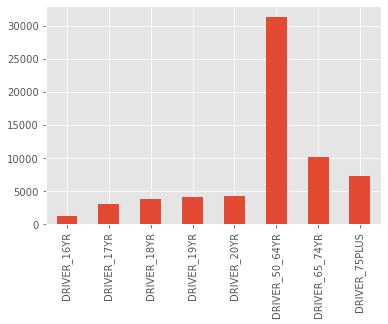

In [24]:
# Driver Age Distribution of Major Injury/Death Accients
age_vars = ['DRIVER_16YR', 'DRIVER_17YR', 'DRIVER_18YR', 'DRIVER_19YR', 'DRIVER_20YR', 'DRIVER_50_64YR', 'DRIVER_65_74YR', 'DRIVER_75PLUS']
df_injuries_death = df[(df['any_injuries']) | (df['any_fatalities'])]
df_injuries_death[age_vars].sum().plot(kind='bar')

In [34]:
df['FATAL_OR_MAJ_INJ']

0         0
1         0
2         0
3         0
4         0
         ..
216619    0
216620    0
216621    0
216622    0
216623    0
Name: FATAL_OR_MAJ_INJ, Length: 216624, dtype: int64

<AxesSubplot:xlabel='FATAL_OR_MAJ_INJ'>

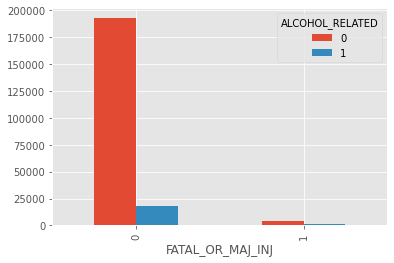

In [42]:
# Alcohol related
df[['ALCOHOL_RELATED', 'FATAL_OR_MAJ_INJ']].value_counts()\
    .reset_index()\
    .pivot(index='FATAL_OR_MAJ_INJ', columns='ALCOHOL_RELATED', values=0)\
    .plot(kind='bar')

<AxesSubplot:xlabel='WEATHER'>

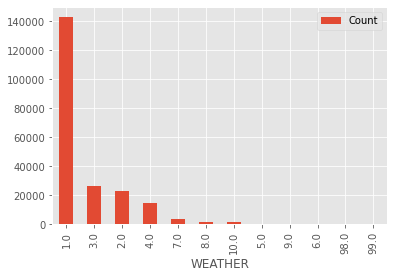

In [53]:
# weather conditions (need to figure out the weather codes)
df[['WEATHER']].value_counts()\
    .reset_index()\
    .set_index('WEATHER')\
    .rename(columns={0:'Count'})\
    .plot(kind='bar')

In [134]:
# Road Condition
road_conditions = ['WET_ROAD', 'SNOW_SLUSH_ROAD', 'ICY_ROAD']
df[road_conditions + ['any_injuries', 'any_fatalities']]

,WET_ROAD,SNOW_SLUSH_ROAD,ICY_ROAD,any_injuries,any_fatalities
0,0,0,0,False,False
1,0,0,1,True,False
2,0,0,0,True,False
3,1,0,0,True,False
4,0,0,0,False,False
...,...,...,...,...,...
216619,1,0,0,False,False
216620,0,0,0,True,False
216621,0,0,0,False,False
216622,1,0,0,True,False


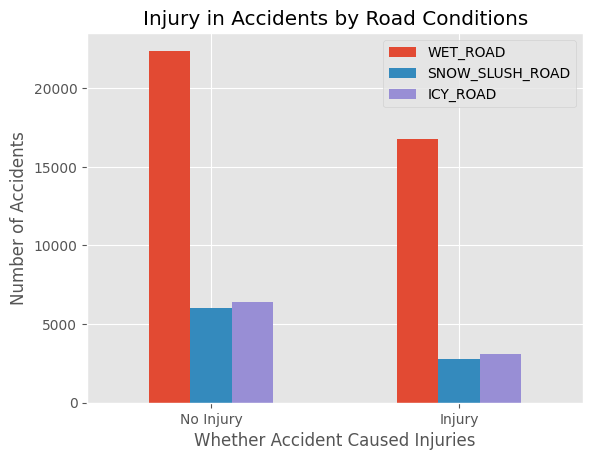

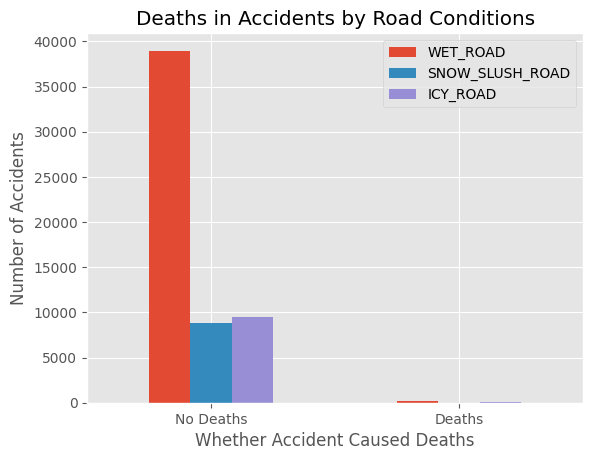

In [173]:
# Specific kinds of roads

# Convert the 'any_injuries' column to a boolean variable
df['any_injuries'] = df['any_injuries'].astype(bool)
df['any_fatalities'] = df['any_fatalities'].astype(bool)
grouped_df_1 = df.groupby(['any_injuries'])[['WET_ROAD', 'SNOW_SLUSH_ROAD', 'ICY_ROAD']].sum()
grouped_df_2 = df.groupby(['any_fatalities'])[['WET_ROAD', 'SNOW_SLUSH_ROAD', 'ICY_ROAD']].sum()

# Create the bar graph for injuries
grouped_df_1[['WET_ROAD', 'SNOW_SLUSH_ROAD', 'ICY_ROAD']].plot(kind='bar')
plt.xlabel('Whether Accident Caused Injuries')
plt.ylabel('Number of Accidents')
plt.title('Injury in Accidents by Road Conditions')
plt.xticks([0,1], ['No Injury', 'Injury'], rotation= 'horizontal')
plt.show()

# Create the bar graph for deaths
grouped_df_2[['WET_ROAD', 'SNOW_SLUSH_ROAD', 'ICY_ROAD']].plot(kind='bar')
plt.xlabel('Whether Accident Caused Deaths')
plt.ylabel('Number of Accidents')
plt.title('Deaths in Accidents by Road Conditions')
plt.xticks([0,1], ['No Deaths', 'Deaths'], rotation= 'horizontal')
plt.show()

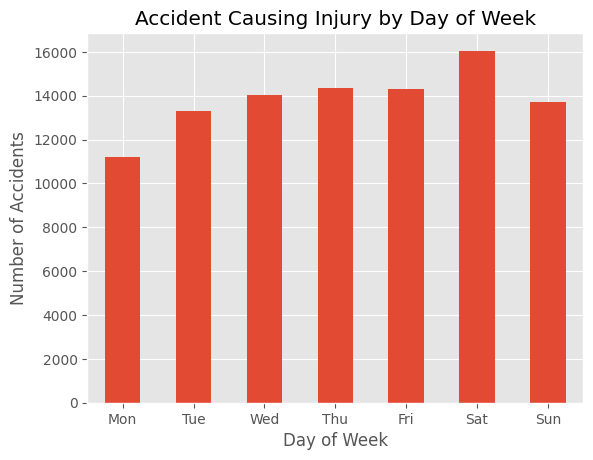

In [191]:
# specific time of day - Injuries

df.groupby(['DAY_OF_WEEK'])[['any_injuries']].sum().plot(kind='bar', legend=None)
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.title('Accident Causing Injury by Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation= 'horizontal')
plt.show()


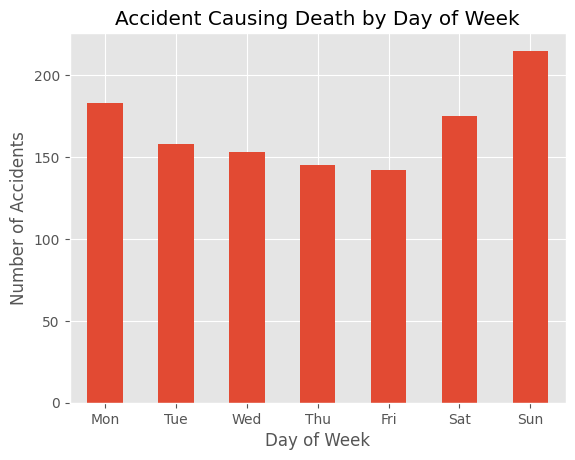

In [189]:
# specific time of day -Deaths

df.groupby(['DAY_OF_WEEK'])[['any_fatalities']].sum().plot(kind='bar', legend = None)
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.title('Accident Causing Death by Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation= 'horizontal')
plt.show()

([<matplotlib.axis.XTick at 0x26ee1405030>,
 [Text(0, 0, 'No Injury'), Text(1, 0, 'Injury')])

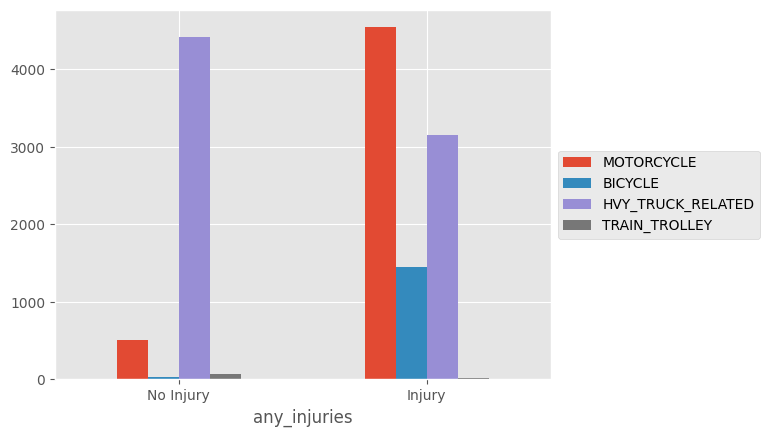

In [199]:
# Vehicle type and Injury

df.groupby(['any_injuries' ])[['MOTORCYCLE', 'BICYCLE', 'HVY_TRUCK_RELATED', 'TRAIN_TROLLEY' ]].sum().plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([0,1], ['No Injury', 'Injury'], rotation= 'horizontal')

([<matplotlib.axis.XTick at 0x26ee187e7a0>,
 [Text(0, 0, 'No Death'), Text(1, 0, 'Death')])

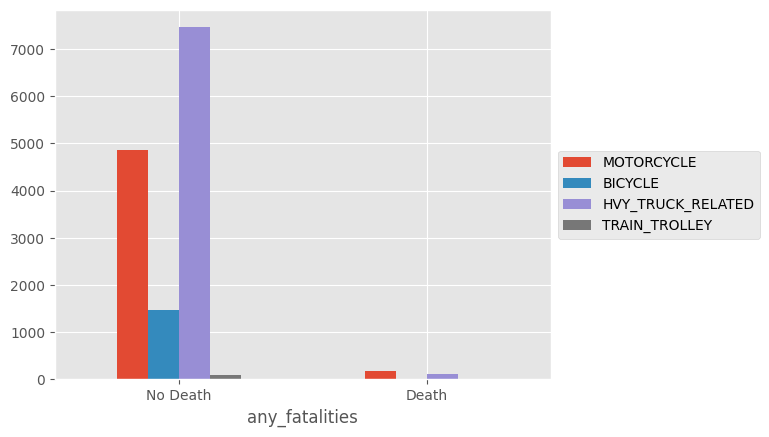

In [206]:
# Vehicle type and Death

df.groupby(['any_fatalities' ])[['MOTORCYCLE', 'BICYCLE', 'HVY_TRUCK_RELATED', 'TRAIN_TROLLEY' ]].sum().plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([0,1], ['No Death', 'Death'], rotation= 'horizontal')

<AxesSubplot:xlabel='Number of Accidents Causing Injury', ylabel='Cause of Injury'>

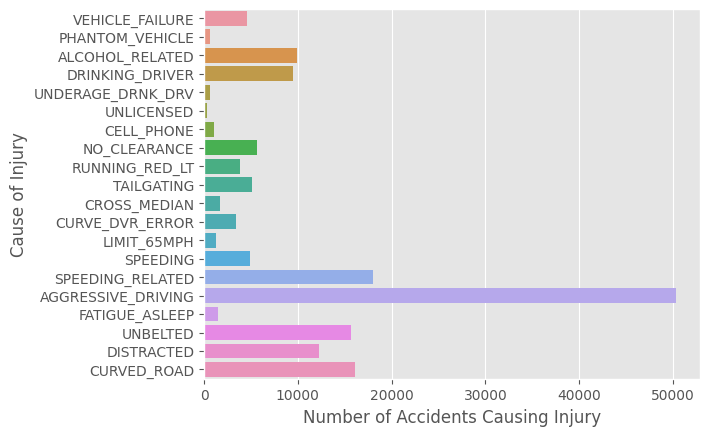

In [228]:
# Cause of Accident and Injury

plot_df = pd.DataFrame(df.loc[df['any_injuries']==1][['VEHICLE_FAILURE', 'PHANTOM_VEHICLE', 'ALCOHOL_RELATED', 'DRINKING_DRIVER', 'UNDERAGE_DRNK_DRV',
'UNLICENSED', 'CELL_PHONE', 'NO_CLEARANCE', 'RUNNING_RED_LT', 'TAILGATING', 'CROSS_MEDIAN', 'CURVE_DVR_ERROR', 'LIMIT_65MPH',
'SPEEDING', 'SPEEDING_RELATED', 'AGGRESSIVE_DRIVING', 'FATIGUE_ASLEEP', 'UNBELTED', 'DISTRACTED', 'CURVED_ROAD' ]].sum()).reset_index()
plot_df = plot_df.rename(columns={'index':'Cause of Injury', 0: 'Number of Accidents Causing Injury'})

sns.barplot(data=plot_df, y = 'Cause of Injury', x='Number of Accidents Causing Injury', orient='h')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.xticks([0,1], ['No Injury', 'Injury'], rotation= 'horizontal')



<AxesSubplot:xlabel='Number of Accidents Causing Death', ylabel='Cause of Death'>

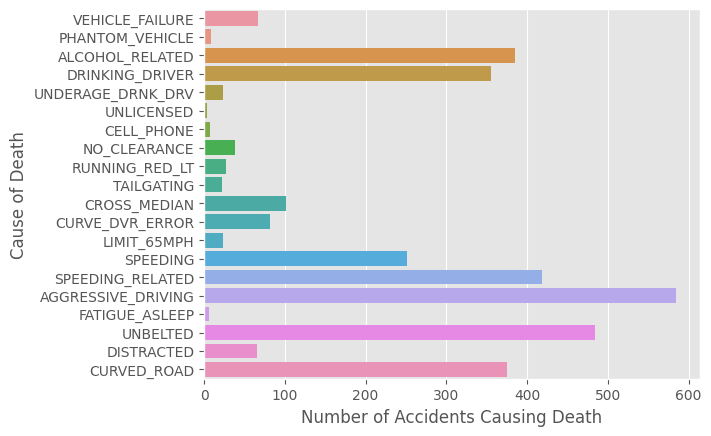

In [231]:
# Cause of Accident and Death

plot_df = pd.DataFrame(df.loc[df['any_fatalities']==1][['VEHICLE_FAILURE', 'PHANTOM_VEHICLE', 'ALCOHOL_RELATED', 'DRINKING_DRIVER', 'UNDERAGE_DRNK_DRV',
'UNLICENSED', 'CELL_PHONE', 'NO_CLEARANCE', 'RUNNING_RED_LT', 'TAILGATING', 'CROSS_MEDIAN', 'CURVE_DVR_ERROR', 'LIMIT_65MPH',
'SPEEDING', 'SPEEDING_RELATED', 'AGGRESSIVE_DRIVING', 'FATIGUE_ASLEEP', 'UNBELTED', 'DISTRACTED', 'CURVED_ROAD' ]].sum()).reset_index()
plot_df = plot_df.rename(columns={'index':'Cause of Death', 0: 'Number of Accidents Causing Death'})

sns.barplot(data=plot_df, y = 'Cause of Death', x='Number of Accidents Causing Death', orient='h')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.xticks([0,1], ['No Injury', 'Injury'], rotation= 'horizontal')
